In [1]:
import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image, ImageDraw
import pandas as pd
import scipy.special as sp
import scipy.stats as sp
import scipy.linalg as sl
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
%pip install -upgrade ipywidgets
clear_output()
#update

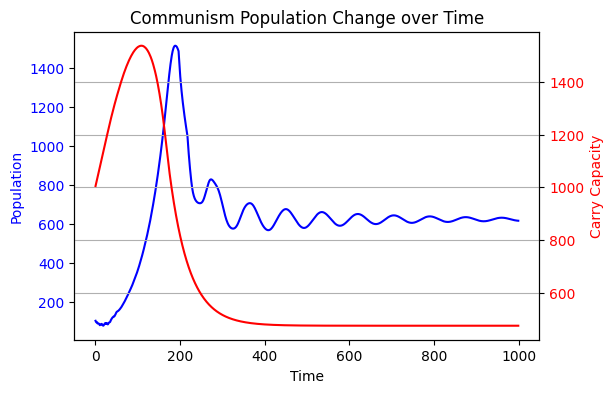

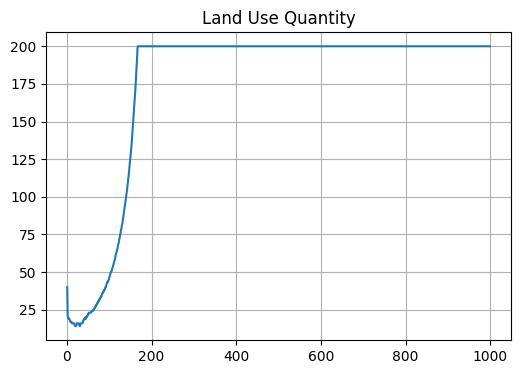

In [125]:
vec1 = pd.read_csv('demog_vectors.csv')
tmp1 = pd.DataFrame({'z': [], 'r': []})  # Initialize an empty DataFrame

# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land, support):
    def generate_left_skewed_proportions(num_elements):
        data = skewnorm.rvs(a=-2, loc=0.4, scale=0.2, size=num_elements)
        data = data[data >= 0]
        proportions = data / np.sum(data)
        # Ensure that there are exactly num_elements proportions (padding with zeros if necessary)
        if len(proportions) < num_elements:
            proportions = np.append(proportions, [0] * (num_elements - len(proportions)))
        return proportions

    # Generate age groups and their corresponding proportions to match p0 rows in vec1
    num_p0_rows = vec1.shape[0]
    age_groups = [f'Age Group {i}' for i in range(num_p0_rows)]
    age_proportions = generate_left_skewed_proportions(num_p0_rows)
    age_proportions = np.array(age_proportions) / np.sum(age_proportions)

    if len(age_proportions) < num_p0_rows: # make sure age_proportions matches the number of rows in vec1
        age_proportions = np.append(age_proportions, 0)  # add a zero proportion for the extra age group
    
    population_matrix = initial_population * age_proportions
    
    # Get the Leslie matrix for a given food ratio (z) using the parameters
    def get_matrix(z, vec1):
        p0 = vec1.pstar * sp.gdtr(1.0/vec1.mortscale[0], vec1.mortparms, z) # pstar - vector - baseline survival prob for use w E < 1, they make gamma cdf give correct answer when E=1
        m0 = vec1.mstar * sp.gdtr(1.0/vec1.fertscale[0], vec1.fertparm[0], z) # mstar - vector - baseline fertility prob for use w E < 1, they make gamma cdf give correct answer when E=1
        if z > 1.5: m0 *= z  # change the fertility mutiplication with z
        if z < 1.2 : m0 *= z
        N = len(p0)
        m1 = np.zeros([N,N])
        for i in range(N-1):
            m1[i+1,i] = p0[i]
        m1[0,] = m0
        return m1

    def update_population_matrix(population_matrix, vec1, z):
        new_population_matrix = np.zeros_like(population_matrix)
        m1 = get_matrix(z, vec1)
        for i in range(len(population_matrix)):
            age_group = age_groups[i]
            row_idx = age_groups.index(age_group)  # Get the corresponding row index from age_groups
            new_population_matrix[i] = np.matmul(population_matrix, m1[row_idx]) # Use the correct row from m1
        return new_population_matrix
     
    ### d is natural death rate    
    populations = [initial_population]  # store population values over time
    P_values = [[0] * initial_population for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] * initial_population for _ in range(simulation_time)] # using land or not decision
    L_values = [initial_capacity for _ in range(initial_lands)] 
    K_values = [] # land carry capacity  
    age_distributions_over_time = []

    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_population): 
                land_assignments[0][i] = { #i is from 0 to initial_population - 1. At this moment, initial population == land numbers
                    'landlord': i, 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    K_t = [land_assignments[0][i]['carry_capacity'] for i in range(initial_population)] 
    
    ### Farming Process
        ### Define the function
        
    def find_top_lands(K_t, populations):
        sorted_lands = sorted(enumerate(K_t), key=lambda x: x[1], reverse=True)
        cumulative_utility = 0
        selected_lands = []
        for land_index, utility in sorted_lands:
            cumulative_utility += utility
            selected_lands.append(land_index)
            if float(cumulative_utility) >= float(populations[-1]):  # Update the comparison here
                break
        if len(selected_lands) > populations[-1]:  # Update the comparison here
            selected_lands = selected_lands[:int(populations[-1])]  # Update the slicing here
        else:
            pass
        return selected_lands

   
    ### Updating process for each year
    for t in range(1, simulation_time): # time 0 is already updated.
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_population)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands = find_top_lands(K_t, populations) # select top lands in each year
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_population): #should I give everyone an agent identity?
                land_assignments[t][i] = {
                    'landlord': i,
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }

        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_population)] # get to use the land or not binary value u
        P = sum([a * b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).         
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity

    #   updating land capacity
        for i in range(initial_population):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * land_assignments[t-1][i]['carry_capacity'] * u_t[i])) ############
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_population)] ## list of each land cell capacity (new year, this year)

        # Calculate the Leslie matrix for the current food ratio (z)
        # I can add the feedback mechanism here by rescaling the z, so the resource using can be slower when the food availability is low.
        z = P / N_t # food availability parameter == carry capacity in my case 
        if z == 0: z = 0.0001

        # apply leslie population change factors
        last_year_population = population_matrix
        population_matrix = update_population_matrix(population_matrix, vec1, z)
        actual_growth = np.sum(population_matrix) - np.sum(last_year_population)

        r = ((np.sum(population_matrix) - np.sum(last_year_population)) / np.sum(last_year_population)) * 100 # population growth rate. this variable is not important
        start_age_group = 30 # farming available groups
        end_age_group = 50
        start_idx = age_groups.index(f'Age Group {start_age_group}')
        end_idx = age_groups.index(f'Age Group {end_age_group}')
        farmer_ability = np.sum(population_matrix[start_idx:end_idx+1]) * support
        
        if P  == 0: P = 0.1
        if N_t == 0: N_t = 0.15
        tmp1 = tmp1.append({'z': z, 'r': r}, ignore_index=True)  # Append the new row to the DataFrame. this is not important
        final_new_population = min(np.sum(population_matrix), farmer_ability)

        # print('actual_growth: ', actual_growth, 'farmer_ability: ', farmer_ability)

        age_distributions_over_time.append(population_matrix) #can be used to plot 
        populations.append(final_new_population)
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
    populations = populations[1:] # exclude the zero year population 
    return populations, K_values, P_values, u_values, age_distributions_over_time, land_assignments

def plot_commuism_simulation_population2(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land, support):
    
    populations, K, _, U, age, data = communism_simulation_population_original(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land, support)
    
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid(True)
    plt.title('Communism Population Change over Time')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(time_steps, [sum(i) for i in U][:-1])
    plt.grid(True)
    plt.title('Land Use Quantity')
    plt.show()

k = 0.001 # land recovery rate
a = 0.02 # soil loss rate
simulation_time = 1000 #simulation year
initial_population = 200
initial_capacity = 5
initial_lands = 400
max_capacity_one_land = 50
support = 3
plot_commuism_simulation_population2(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land, support)

I should add the feedback mechanism. After that, I feel like the K and N are a bit seperated.  
Why did the population goes down??

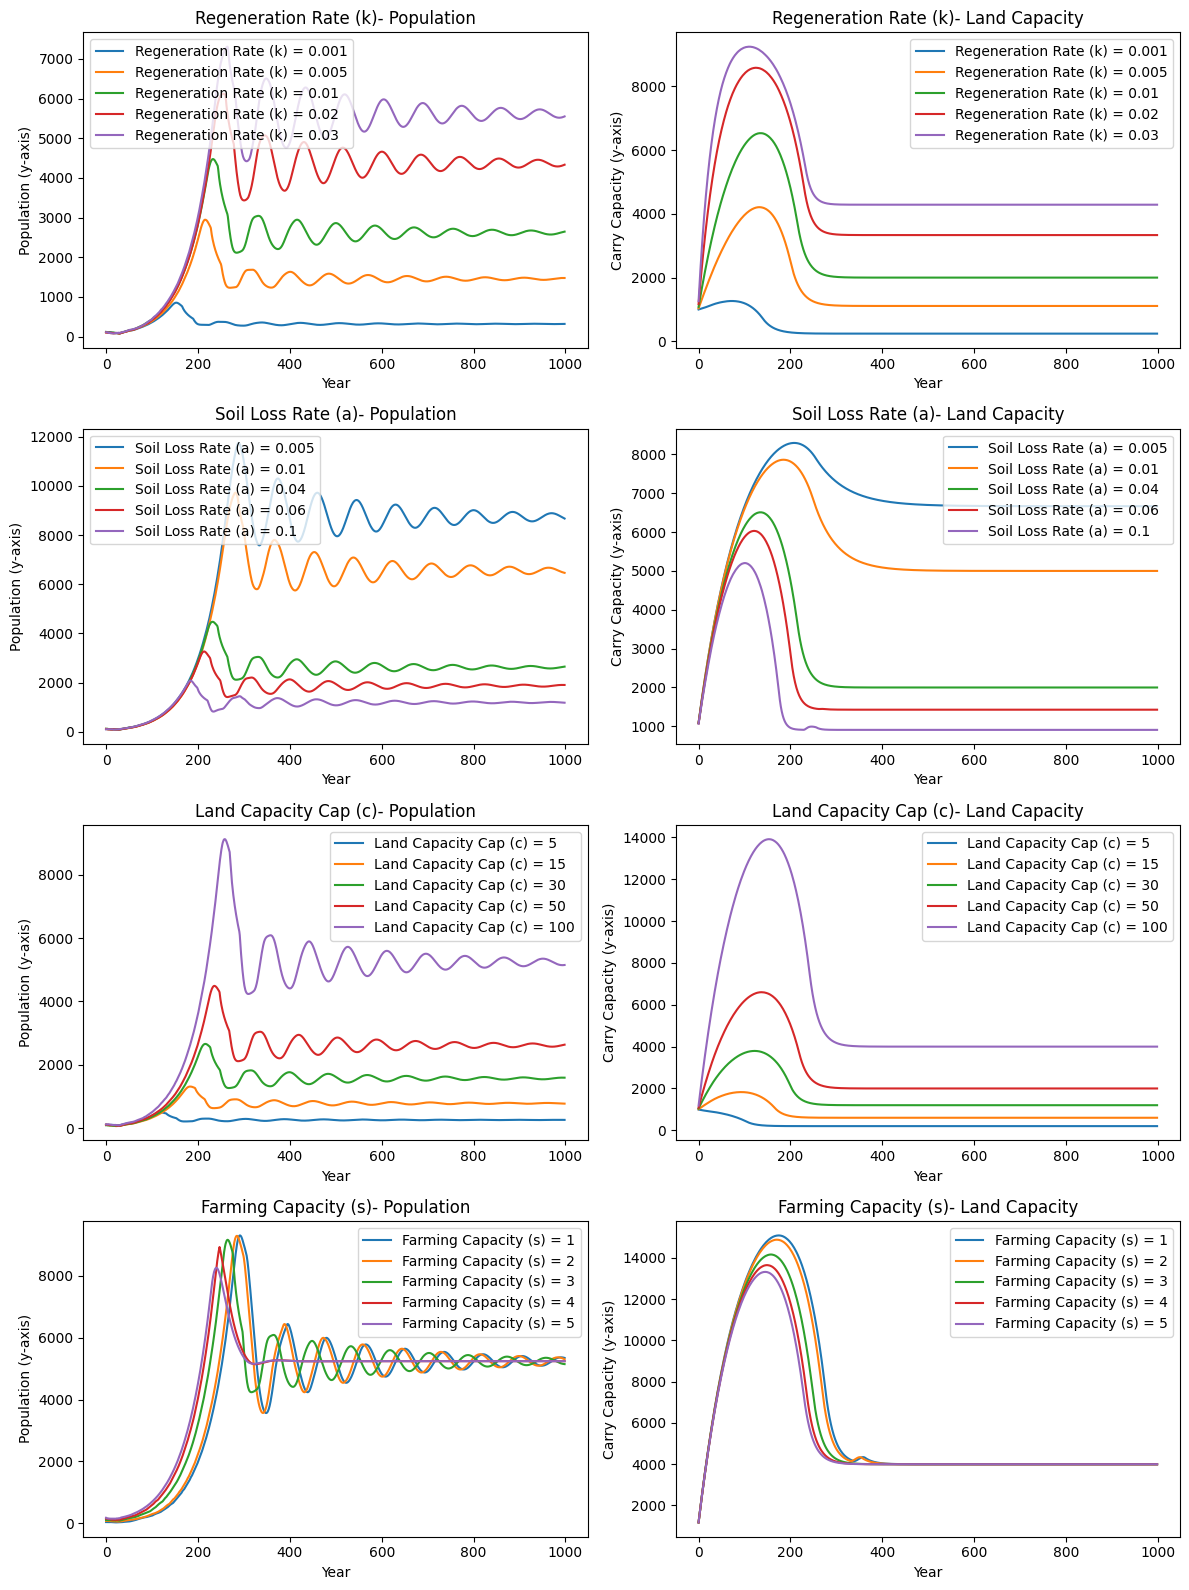

In [123]:
k_range = [0.001, 0.005, 0.01, 0.02, 0.03]
a_range = [0.005, 0.01, 0.04, 0.06, 0.1]
c_range = [5, 15, 30, 50, 100]
s_range = [1, 2, 3, 4, 5]

baseline_s = 3 
baseline_k = 0.01  
baseline_d = 0.001  
baseline_c = 50  
baseline_a = 0.04  

# Vary k while keeping other parameters constant
k_result_pop = []
k_result_food = []
for k in k_range:
    result, cap, _, _, _, _= communism_simulation_population_original(tmp1, vec1, k, baseline_a, initial_population, initial_lands, simulation_time, initial_capacity,  baseline_c, baseline_s)
    k_result_pop.append(result)
    k_result_food.append(cap)
# print('pass')
# Vary a while keeping other parameters constant
a_result_pop = []
a_result_food = []
for a in a_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(tmp1, vec1, baseline_k, a, initial_population, initial_lands, simulation_time, initial_capacity, baseline_c, baseline_s)
    a_result_pop.append(result)
    a_result_food.append(cap)
# print('pass')
# Vary c while keeping other parameters constant
c_result_pop = []
c_result_food = []
for c in c_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(tmp1, vec1, baseline_k, baseline_a, initial_population, initial_lands, simulation_time, initial_capacity, c, baseline_s)
    c_result_pop.append(result)
    c_result_food.append(cap)
# print('pass')

s_result_pop = []
s_result_food = []
for s in s_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(tmp1, vec1, baseline_k, baseline_a, initial_population, initial_lands, simulation_time, initial_capacity, c, s)
    s_result_pop.append(result)
    s_result_food.append(cap)
# print('pass')
parameters = [('Regeneration Rate (k)', k_range, k_result_pop, k_result_food),
              ('Soil Loss Rate (a)', a_range, a_result_pop, a_result_food),
              ('Land Capacity Cap (c)', c_range, c_result_pop, c_result_food),
              ('Farming Capacity (s)', s_range, s_result_pop, s_result_food)]

fig, axs = plt.subplots(len(parameters), 2, figsize=(12, 16))

for i, (param_name, param_range, result_pop, result_food) in enumerate(parameters):
    for j in range(len(param_range)):
        axs[i, 0].plot(result_pop[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 0].set_xlabel('Year')
    axs[i, 0].set_ylabel('Population (y-axis)')
    axs[i, 0].set_title(param_name + "- Population")
    axs[i, 0].legend()

    for j in range(len(param_range)):
        axs[i, 1].plot(result_food[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 1].set_xlabel('Year')
    axs[i, 1].set_ylabel('Carry Capacity (y-axis)')
    axs[i, 1].set_title(param_name + "- Land Capacity")
    axs[i, 1].legend()

plt.tight_layout()
plt.show()
